In [1]:
%matplotlib inline

In [2]:
import os
import pathlib
import sys
import time

import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [3]:
import jax 
import jax.numpy as jnp
from jax import grad, vmap, lax, random
from jax.experimental.ode import odeint

In [4]:
import numpyro as npr
from numpyro import sample, plate, handlers
import numpyro.distributions as dist
from numpyro.optim import Adam
from numpyro.infer import Predictive, SVI, Trace_ELBO, TraceMeanField_ELBO, init_to_value
from numpyro.infer.autoguide import *

/mnt/data/tng/phd/DCM/DCM_ERP_new/.pymc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
npr.set_platform("cpu")

In [6]:
#See the dependency at last cell!
print(f"Numpy version: {np.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {npr.__version__}")
print(f"Arviz version: {az.__version__}")

Numpy version: 1.24.3
JAX version: 0.4.23
Numpyro version: 0.14.0
Arviz version: 0.18.0


In [7]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [8]:
cwd = os.getcwd()
main_path = str(pathlib.Path.cwd().parent)
sys.path.append(main_path) # Path to import the model and solver

In [9]:
from ForwardModel.ERPmodel_JAX import DCM_ERPmodel, odeint_euler
from Helper.ERPhelper import *

## Purpose

The purpose of this notebook is to demonstrate how to perform Stochastic Variational Inference (SVI) on a system of ordinary differential equations (ODEs) in Numpyro. For an example of ODEs in Numpyro, see ref [1]. The application is to model and fit neuroimaging data such as ERP/EEG/MEG recording (see Ref [2]).

We use Numpyro's Automatic Guides for defining variational families . 

### Key Conclusions

The mean-field gaussian variational approximation provides uncorrelated but overconfident (underdispersed and innacurate) posterior samples. The full-rank approximation mitigates this issue by taking into account correlations between parameters. The Laplace approximation leverages second-order derivatives to approximate the posterior with a gaussian distribution. Laplace approximation performs the best. 

Refs: 

1) https://num.pyro.ai/en/stable/examples/ode.html
    

2) https://www.sciencedirect.com/science/article/abs/pii/S1053811905008013


## Background

### Motivation

Ordinary differential equation models (ODEs) are used in a variety of science and engineering domains to model the time evolution of physical variables.  A natural choice to estimate the values and uncertainty of model parameters given experimental data is Bayesian inference.  However, ODEs can be challenging to specify and solve in the Bayesian setting, therefore, this notebook steps through multiple methods for solving an ODE inference problem using JAX's Odeint. Alternative is to use diffrax, which can be found in forward simulations in the repo. The neural mass model used in this example has often been used in dynamical causal modeling and other approaches to fit various neuroimaging data such as ERP/EEG/MEG.

### Neural Mass Model

The model of Olivier David et al describes the interaction between three neural populations of pyramidal (x9), 
inhibitory interneuron (x7) 
spiny-stellate cells (x1).

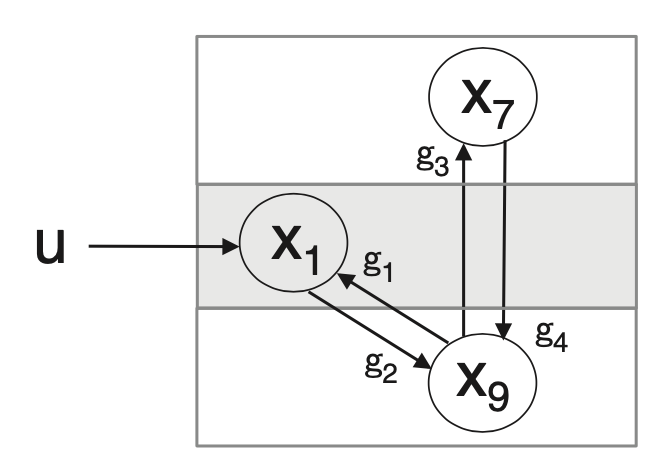

In [10]:
from IPython.display import Image
Image(filename='model.png', width=400)

This ODE given by:




\begin{equation}
    \begin{aligned}
    \dot x_1(t) &= x_4 (t) \\
    \dot x_2(t) &= x_5(t) \\
    \dot x_3(t) &= \dfrac{h_e}{\tau_e} \left( g_1 \left( 
    \dfrac{1}{\exp^{-0.56 x_9 (t - \delta)} + 1} - 0.5 \right) + u \right) - \dfrac{x_1(t)}{\tau_e^2} - \dfrac{2 x_4(t)}{\tau_e} \\
    \dot x_5(t) &= \dfrac{g_2 h_e}{\tau_e}  \left( 
    \dfrac{1}{\exp^{-0.56 x_1 (t - \delta)} + 1} -0.5 \right) - \dfrac{x_2(t)}{\tau_e^2} - \dfrac{2 x_5(t)}{\tau_e} \\
    \dot x_6(t) &= \dfrac{g_4 h_i}{\tau_i}  \left( 
    \dfrac{1}{\exp^{-0.56 x_7 (t - \delta)} + 1} -0.5 \right) - \dfrac{x_3(t)}{\tau_i^2} - \dfrac{2 x_6(t)}{\tau_i} \\
    \dot x_7(t) &= x_8(t) \\
    \dot x_8(t) &= \dfrac{g_3 h_e}{\tau_e}  \left( 
    \dfrac{1}{\exp^{-0.56 x_9 (t - \delta)} + 1} -0.5 \right) - \dfrac{x_7(t)}{\tau_e^2} - \dfrac{2 x_8(t)}{\tau_e} \\
    \dot x_9(t) &= x_5(t) - x_6(t)
\end{aligned}
\end{equation}





The state vector $X(t)=[x_1(t), ...x_9(t)]$ comprises the densities of activity of neural populations. Parameters $\boldsymbol{\theta}=[g_1, g_2, g_3, g_4, \delta,\tau_i, h_i, \tau_e, h_e, u ]$ are the unknowns that we wish to infer from experimental observations.

$x(0)$ represents the initial values of the states needed to solve the ODE and is fixed to zero for all variables.

The unknown model parameters represent the following:

* $g_1, g_2, g_3, g_4$ are connection strengths.
* $\delta$ is the intrinsic delay.
* $h_{e,i}$ represents the maximum amplitude of excitatory (e) and inhibitory (i) post-synaptic potentials.
* $\tau_{e, i}$ are the rate constants for excitatory and inhibitory synaptic inputs, respectively.
* $u$  represents the input to each neural population

## Simulator

In [11]:
rng_key = jax.random.PRNGKey(0)

In [12]:
tend = 200.0
dt = 0.1
t0 = 0.0
ts = np.arange(t0, tend + dt, dt)
nt = ts.shape[0]

ns = 9
x_init=np.zeros((ns))

In [13]:
theta_true = np.array([0.42, 0.76, 0.15, 0.16, 12.13, 7.77, 27.87, 5.77, 1.63, 3.94])
n_params = theta_true.shape[0]
my_var_names = ['g_1', 'g_2', 'g_3', 'g_4', 'delta', 'tau_i', 'h_i', 'tau_e', 'h_e', 'u']

Run the model

In [14]:
%%time
xs_euler = odeint_euler(DCM_ERPmodel, x_init, ts, theta_true)

CPU times: user 108 ms, sys: 12.6 ms, total: 121 ms
Wall time: 119 ms


We use Euler integration (see the ForwardModel for Heun and Rk4 integratores), But don't worry about computional time! we put JAX's JIT on Odeint to make it more faster!

In [15]:
@jax.jit
def ERP_JAXOdeintSimuator(x_init, ts, params):

    xs_rk4 = odeint_euler(DCM_ERPmodel, x_init, ts, params)    
    x_py=xs_rk4[:,8]
    
    return x_py

The initial compilation takes a bit of time, but after that, it flies through the air!

In [16]:
start_time = time.time()

xpy_jax=ERP_JAXOdeintSimuator(x_init, ts, theta_true)

print("simulation with compiling took (sec):" , (time.time() - start_time))

simulation with compiling took (sec): 0.09047985076904297


In [17]:
start_time = time.time()

xpy_jax=ERP_JAXOdeintSimuator(x_init, ts, theta_true)

print("simulation using JAX's JIT took (sec):" , (time.time() - start_time))

simulation using JAX's JIT took (sec): 0.00022602081298828125


## Synthetic Observation

We assume that we only have access to the activity of pyramidal neurons, and for the sake of speeding the computational time, we downsample the simuations.

In [18]:
#observation noise
sigma_true = 0.1 

In [19]:
xpy_jax = ERP_JAXOdeintSimuator(x_init, ts, theta_true)
x_noise = np.random.normal(loc=0, scale=sigma_true, size=xpy_jax.shape)
x_py = xpy_jax + x_noise

In [20]:
#downsampling
ds=10

In [21]:
ts_obs=ts[::ds]
xpy_obs=x_py[::ds]
nt_obs=int(x_py[::ds].shape[0])

In [22]:
ts_obs.shape, xpy_obs.shape, nt_obs

((201,), (201,), 201)

In [23]:
data = { 'nt_obs': nt_obs, 'ds': ds, 'ts': ts, 'ts_obs': ts_obs, 'dt': dt, 'x_init': x_init, 'obs_err': sigma_true, 'xpy_obs': xpy_obs }

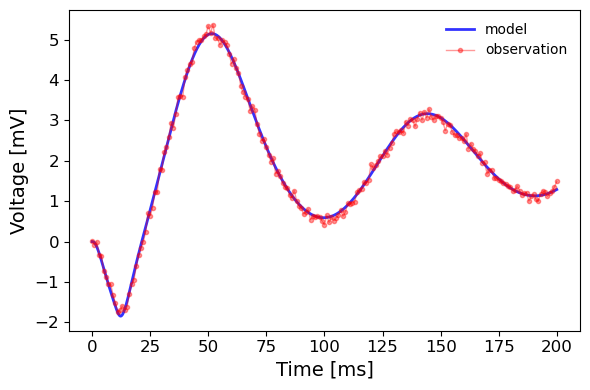

In [24]:
plot_observation(ts, xpy_jax, ts_obs, xpy_obs);

## Prior

Since all the parameters are positive, we place Gamma prior, according to Refs [3,4].

In [25]:
shape=[18.16, 29.9, 29.14, 30.77, 22.87, 34.67, 20.44, 33.02, 24.17, 23.62]
scale=[0.03, 0.02, 0.005, 0.007, 0.51, 0.23, 0.96, 0.16, 0.07, 0.13]
rate = 1. / np.array(scale)
prior_specs = dict(shape=shape, rate=rate)

In [26]:
def model(data, prior_specs):
    #Data
    dt = data['dt']
    ts = data['ts']
    ds = data['ds']
    nt_obs = data['nt_obs']
    x_init = data['x_init']
    obs_err= data['obs_err']
    xpy_obs = data['xpy_obs']

    # Prior               
    g_1 = npr.sample('g_1', dist.Gamma(prior_specs['shape'][0], prior_specs['rate'][0]))
    g_2 = npr.sample('g_2', dist.Gamma(prior_specs['shape'][1], prior_specs['rate'][1]))
    g_3 = npr.sample('g_3', dist.Gamma(prior_specs['shape'][2], prior_specs['rate'][2]))
    g_4 = npr.sample('g_4', dist.Gamma(prior_specs['shape'][3], prior_specs['rate'][3]))
    delta = npr.sample('delta', dist.Gamma(prior_specs['shape'][4], prior_specs['rate'][4]))
    tau_i = npr.sample('tau_i', dist.Gamma(prior_specs['shape'][5], prior_specs['rate'][5]))
    h_i = npr.sample('h_i', dist.Gamma(prior_specs['shape'][6], prior_specs['rate'][6]))
    tau_e = npr.sample('tau_e', dist.Gamma(prior_specs['shape'][7], prior_specs['rate'][7]))
    h_e = npr.sample('h_e', dist.Gamma(prior_specs['shape'][8], prior_specs['rate'][8]))
    u = npr.sample('u', dist.Gamma(prior_specs['shape'][9], prior_specs['rate'][9]))
     
    #Parameters    
    params_samples=[g_1, g_2, g_3, g_4, delta, tau_i,  h_i, tau_e, h_e, u]
    
    #Forward model
    xpy_hat=ERP_JAXOdeintSimuator(x_init, ts, params_samples)[::ds]
    
    # Likelihood
    with plate('data', size=nt_obs):
        xpy_model = npr.deterministic('xpy_model', xpy_hat)
        npr.sample('xpy_obs', dist.Normal(xpy_model, sigma_true), obs=xpy_obs) 

### Prior predictive check

In [27]:
n_ = 100
prior_predictive = Predictive(model, num_samples=n_)
prior_predictions = prior_predictive(rng_key, data, prior_specs)

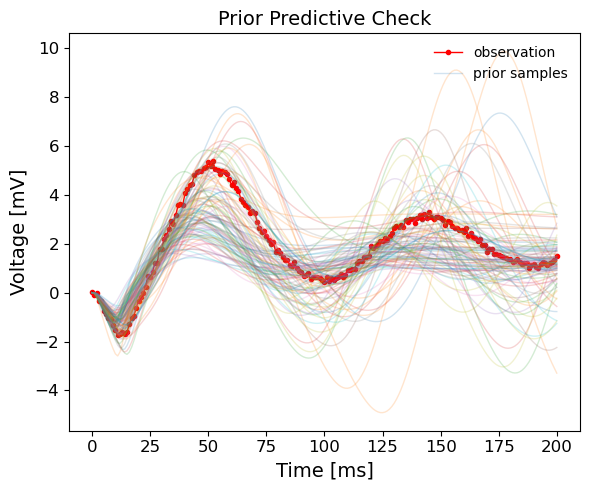

In [28]:
title='Prior Predictive Check'
plot_priorcheck(ts_obs, xpy_obs, prior_predictions, n_, title);

# Stochastic Variational Inference

We define global parameters for SVI, regardless of the guide.

In [29]:
lr = 0.0005 #learning rate for the optimizer
n_iters = 100000  #number of iteration for the optimizer
optimizer = Adam(lr)

And a function for initialization at the tails of the priors

In [30]:
rng_key = jax.random.PRNGKey(0)
init_params=tails_percentile(my_var_names, prior_predictions, 0.05)    
init_fn = init_to_value(values=init_params)

In [31]:
n_samples = 1000 #number of posterior samples

## Mean-field approximation

The mean-field approximation posits a factorized Gaussian distribution $q(\theta) \equiv \prod_{i=1}^K \mathcal{N}(\mu_i, \sigma_i)$ as the target posterior to be optimized, which ignores off-diagonal correlations between model parameters $\theta_1, ..., \theta_K$.

In [32]:
guide_mf = AutoDiagonalNormal(model, init_loc_fn=init_fn)
svi_mf = SVI(model, guide_mf, optimizer, loss=Trace_ELBO())

In [33]:
start = time.time()
init_state = svi_mf.init(rng_key, data, prior_specs)
svi_mf_result = svi_mf.run(rng_key, n_iters, data, prior_specs, init_state=init_state)
time_mf = time.time() - start
print(print('SVI mean-field took ', time_mf, ' seconds'))

100%|██████████| 100000/100000 [00:34<00:00, 2892.33it/s, init loss: 40874.2852, avg. loss [95001-100000]: -150.6216]


SVI mean-field took  48.595616817474365  seconds
None


In [34]:
loss_mf = svi_mf_result.losses
params_mf = svi_mf_result.params
posterior_mf = guide_mf.sample_posterior(rng_key, params_mf, sample_shape=(1, n_samples))

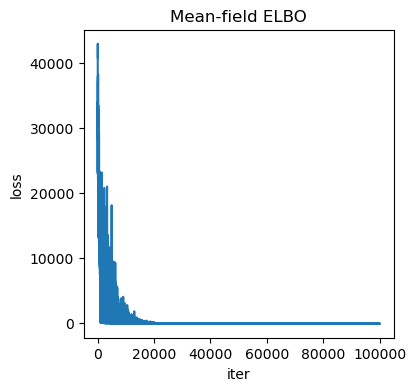

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4)) 
ax.plot(loss_mf)
ax.set(xlabel='iter', ylabel='loss', title='Mean-field ELBO')
fig.show()

In [36]:
az_post_mf = az.from_dict(posterior_mf)

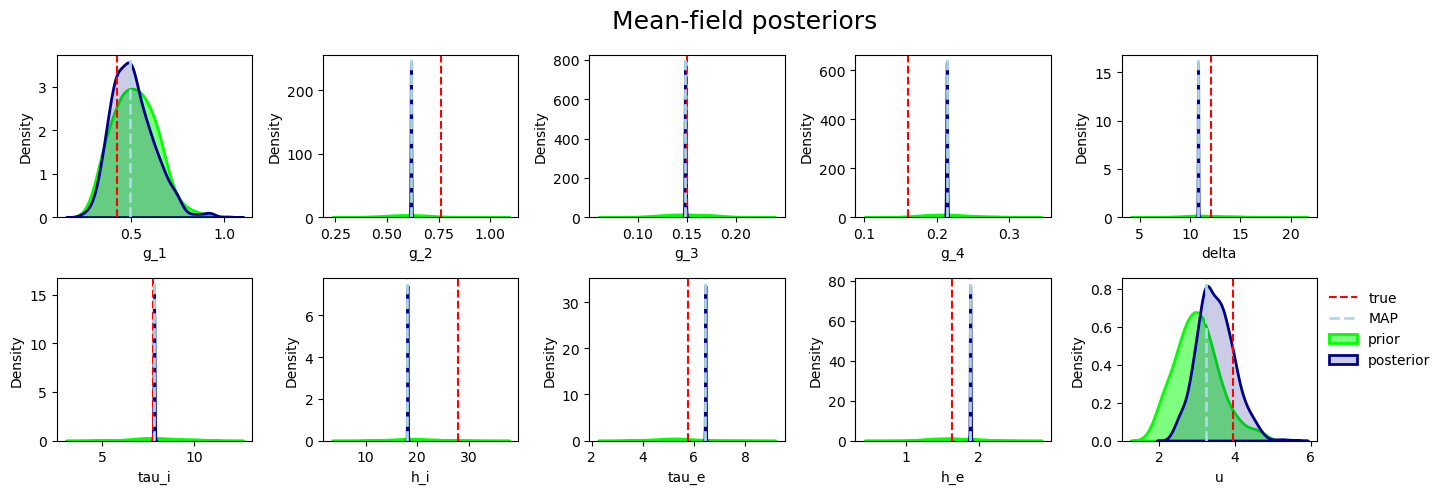

In [37]:
fig, ax = plot_posterior_pooled(my_var_names, theta_true, prior_predictions, az_post_mf.posterior[my_var_names].to_array().values.reshape(n_params, -1), 'Mean-field posteriors')
ax[-1, -1].legend(frameon=False, labels=['true', 'MAP', 'prior', 'posterior'], bbox_to_anchor=(1, 1))
fig.show()

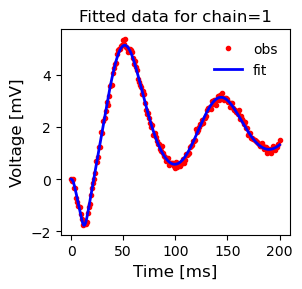

In [38]:
fig, ax =  plot_fitted(data, az_post_mf.posterior)
for a in ax[1:] : 
    a.set_visible(False)

## Full-rank approximation

The full-rank approximation sets the target posterior to a multivariate guassian distribution $q(\theta) \equiv \mathcal{N}(\mu, \Sigma)$, thereby modelling correlations between model parameters.

In [39]:
guide_fr = AutoMultivariateNormal(model, init_loc_fn=init_fn)
svi_fr = SVI(model, guide_fr, optimizer, loss=Trace_ELBO())

In [40]:
start = time.time()
init_state = svi_fr.init(rng_key, data, prior_specs)
svi_fr_result = svi_fr.run(rng_key, n_iters, data, prior_specs, init_state=init_state)
time_fr = time.time() - start
print(print('SVI full-rank took ', time_fr, ' seconds'))

100%|██████████| 100000/100000 [00:37<00:00, 2684.95it/s, init loss: 40874.2734, avg. loss [95001-100000]: -162.9560]


SVI full-rank took  48.700345516204834  seconds
None


In [41]:
loss_fr = svi_fr_result.losses
params_fr = svi_fr_result.params
posterior_fr = guide_fr.sample_posterior(rng_key, params_fr, sample_shape=(1, n_samples))

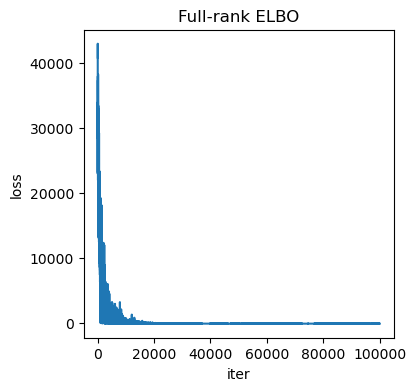

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4)) 
ax.plot(loss_fr)
ax.set(xlabel='iter', ylabel='loss', title='Full-rank ELBO')
fig.show()

In [43]:
az_post_fr = az.from_dict(posterior_fr)

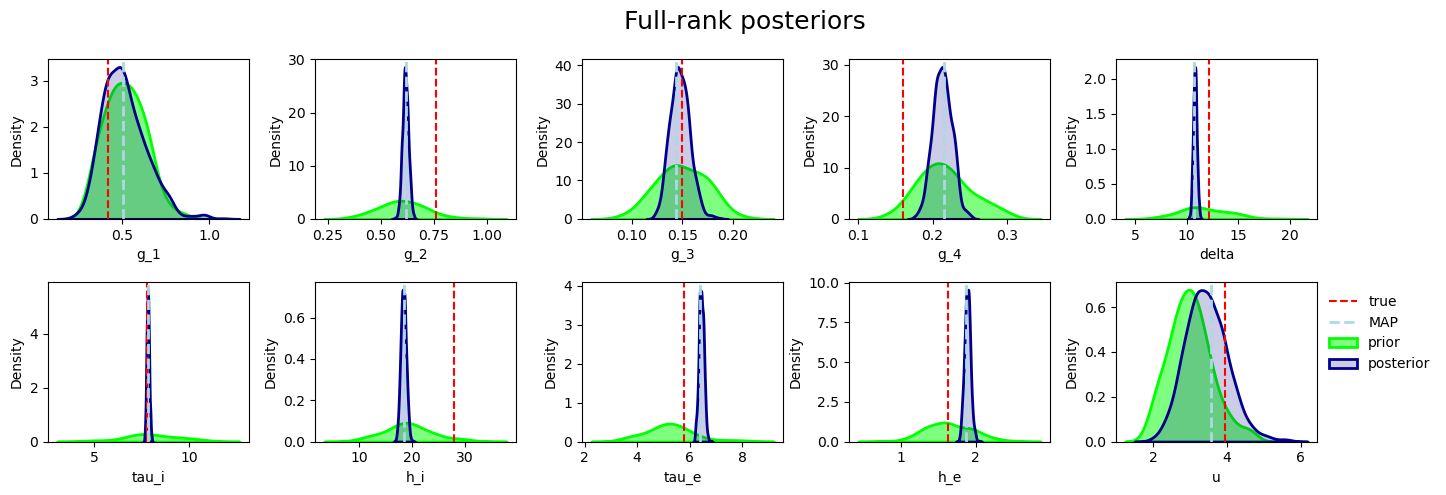

In [44]:
fig, ax = plot_posterior_pooled(my_var_names, theta_true, prior_predictions, az_post_fr.posterior[my_var_names].to_array().values.reshape(n_params, -1), 'Full-rank posteriors')
ax[-1, -1].legend(frameon=False, labels=['true', 'MAP', 'prior', 'posterior'], bbox_to_anchor=(1, 1))
fig.show()

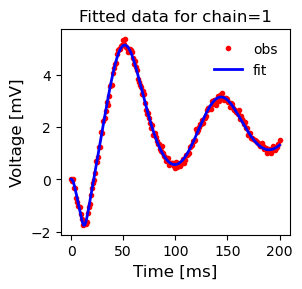

In [45]:
fig, ax =  plot_fitted(data, az_post_fr.posterior)
for a in ax[1:] : 
    a.set_visible(False)

## Laplace approximation

The Laplace approximation leverages a quadratic approximation to the variational energy $\log p(data, \theta)$ and defines a proposal quadratic approximated posterior $q(\theta) \equiv \mathcal{N}(\mu, \Sigma^{-1})$, where $\mu= \text{argmax}_{\theta}\log p(data, \theta)$ and $\Sigma=- \dfrac{\partial^2}{\partial \theta^2}\log p(data, \theta) \Bigr\rvert_{\mu}$.  The ELBO under the Laplace approximation is 
$$\text{ELBO}_{\text{Laplace}} = \log p(data, \mu) + \frac{1}{2} \log |\Sigma| + \frac{n_{params}}{2} \log 2 \pi + \frac{n_{params}}{2}$$

In [46]:
guide_lp = AutoLaplaceApproximation(model)
svi_lp = SVI(model, guide_lp, optimizer, loss=Trace_ELBO())

In [47]:
start = time.time()
init_state = svi_lp.init(rng_key, data, prior_specs)
svi_lp_result = svi_lp.run(rng_key, n_iters, data, prior_specs, init_state=init_state)
time_lp = time.time() - start
print(print('Laplace took ', time_lp, ' seconds'))

100%|██████████| 100000/100000 [00:33<00:00, 2944.70it/s, init loss: 74613472.0000, avg. loss [95001-100000]: -193.0780]


Laplace took  44.97369694709778  seconds
None


In [48]:
loss_lp = svi_lp_result.losses
params_lp = svi_lp_result.params
posterior_lp = guide_lp.sample_posterior(rng_key, params_lp, sample_shape=(1, n_samples))

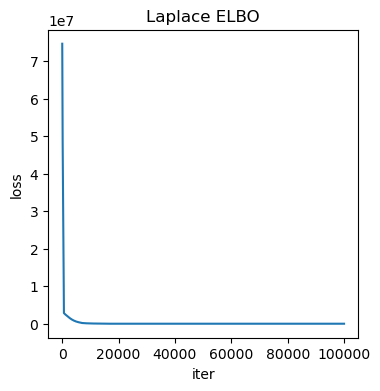

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4)) 
ax.plot(loss_lp)
ax.set(xlabel='iter', ylabel='loss', title='Laplace ELBO')
fig.show()

In [50]:
az_post_lp = az.from_dict(posterior_lp)

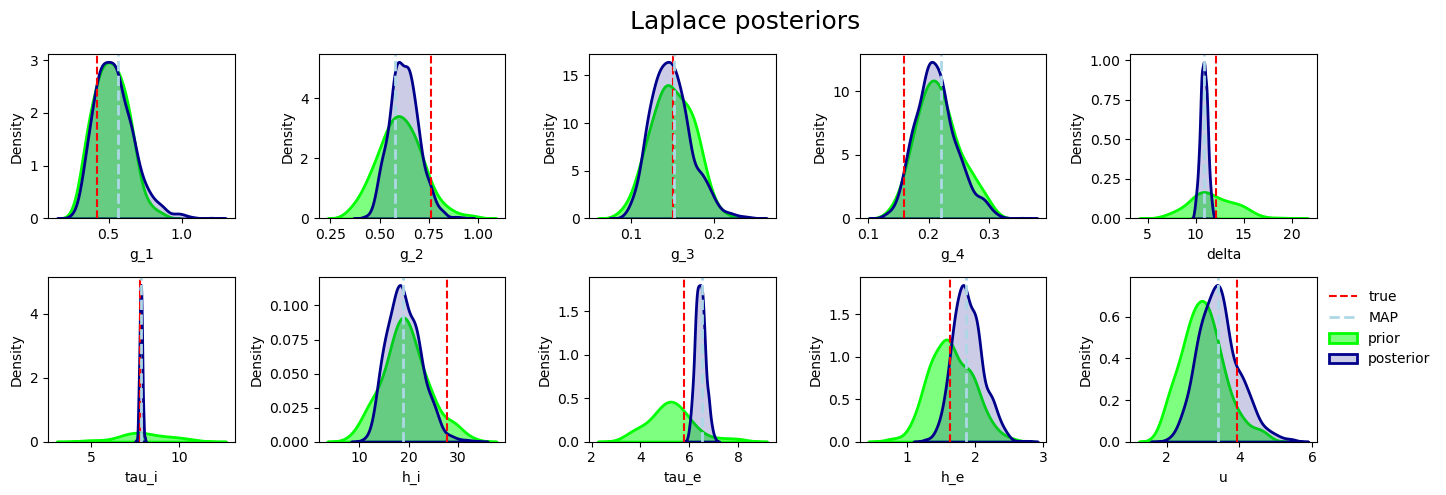

In [51]:
fig, ax = plot_posterior_pooled(my_var_names, theta_true, prior_predictions, az_post_lp.posterior[my_var_names].to_array().values.reshape(n_params, -1), 'Laplace posteriors')
ax[-1, -1].legend(frameon=False, labels=['true', 'MAP', 'prior', 'posterior'], bbox_to_anchor=(1, 1))
fig.show()

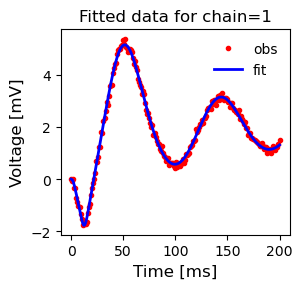

In [52]:
fig, ax =  plot_fitted(data, az_post_lp.posterior)
for a in ax[1:] : 
    a.set_visible(False)

In [53]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Jul 15 2024

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 8.11.0

seaborn     : 0.12.2
numpy       : 1.23.5
numpyro     : 0.12.1
matplotlib  : 3.7.3
jax         : 0.4.13
arviz       : 0.15.1
clb_nb_utils: 0.1.0.dev0

Watermark: 2.4.3

